In [1]:
import numpy as np
import torch
from glob import glob
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from scipy.special import softmax
from scipy.stats import entropy
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from pathlib import Path

In [2]:
def top_eigen(A, n, eps=1e-5):
    '''
    Uses power method to find top eigenvector of nxn matrix A
    A should be a function implementing multiplication v -> Av
    Returns top eigenvector, top eigenvalue
    '''
    v0 = np.zeros((n,))
    v1 = np.random.normal(0, 1, (n,))
    v1 /= np.linalg.norm(v1)
    coef0 = None
    coef1 = None
    while coef0 is None or abs(coef1 - coef0) / abs(coef0) > eps:
        v0 = v1
        v1 = A(v1)
        coef0 = coef1
        coef1 = np.dot(v0, v1)  # = v0.T @ v0. Note ||v0||=1 already here.
        v1 /= np.linalg.norm(v1)
        #print(coef1)
    return v1, np.dot(v1, A(v1))

In [3]:
def eigen_gen(A, n, eps=1e-5):
    vs = []
    lams = []
    cur_A = A
    while True:
        v, lam = top_eigen(cur_A, n, eps=eps)
        vs.append(v)
        lams.append(lam)
        yield v, lam
        cur_A = lambda x: A(x) - sum(lam * np.dot(v, x) * v for v, lam in zip(vs, lams))

def topk_eigen(A, n, k, eps=1e-5):
    '''
    Returns top k eigenvectors (n, k) and eigenvalues (k,)
    '''
    vs = []
    lams = []
    it = eigen_gen(A, n, eps=eps)
    for _ in range(k):
        v, lam = next(it)
        vs.append(v)
        lams.append(lam)
    return np.array(vs).T, np.array(lams)

In [4]:
def topk_svd(A, AT, n, m, k, eps=1e-5, save_name=None):
    '''
    Given nxm matrix A, returns U (n, k), S (n,), VT(k, m).
    A should be provided as two functions v -> Av and v -> ATv
    '''
    u_eigens = eigen_gen(lambda x: A(AT(x)), n, eps=eps)
    v_eigens = eigen_gen(lambda x: AT(A(x)), m, eps=eps)
    U = []
    S = []
    V = []
    Path('SVD').mkdir(exist_ok=True)
    for i in tqdm(range(k)):
        if n < m:
            u, lam = next(u_eigens)
            s = np.sqrt(lam)
            v = AT(u) / s
        else:
            v, lam = next(v_eigens)
            s = np.sqrt(lam)
            u = A(v) / s
        U.append(u)
        S.append(s)
        V.append(v)
        if save_name:
            np.save(f'SVD/{save_name}_U_{i}', u)
            np.save(f'SVD/{save_name}_S_{i}', s)
            np.save(f'SVD/{save_name}_V_{i}', v)
    U, S, V = np.array(U).T, np.array(S), np.array(V).T
    if save_name:
        np.save(f'SVD/{save_name}_U', U)
        np.save(f'SVD/{save_name}_S', S)
        np.save(f'SVD/{save_name}_V', V.T)
    return U, S, V.T

In [5]:
from time import time
TIME = time()
def bench():
    global TIME
    print('TIME ELAPSED:', time() - TIME)
    TIME = time()

In [2]:
ckpt_f = '/workspace/checkpoints/LLAMA2-NECK-SWEEP*/llama-2-7b-hf_hidden_idxs-32_hidden_lb-{}_token_lb-{}_neck_cls-mlp_*'

In [3]:
necks = [
    ('t', '-1', '0'),  # token
    ('h', '0', '-1'),  # hidden
    ('ht', '0', '0'),  # both
]
for name, h, t in necks:
    ckpt = glob(ckpt_f.format(h, t))[0]
    state = torch.load(ckpt)['state_dict']
    globals()[f'W{name}'] = state['future_neck.layers.0.weight'].cpu().numpy()
    globals()[f'b{name}'] = state['future_neck.layers.0.bias'].cpu().numpy()

In [6]:
model_name = 'daryl149/llama-2-7b-hf'
config = AutoConfig.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, config=config)

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [8]:
params = dict(model.named_parameters())
modules = dict(model.named_modules())

In [9]:
E = params['model.embed_tokens.weight'].detach().numpy()
D = params['lm_head.weight'].detach().numpy()

In [146]:
UD, SD, VD = np.linalg.svd(D, full_matrices=False)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
Token = {v: k for k, v in tokenizer.get_vocab().items()}

def topk(v, k=40):
    # Takes in logits
    v = softmax(v.flatten())
    idxs = v.argsort()[-k:][::-1]
    ret = [(Token[i], v[i]) for i in idxs]
    return pd.DataFrame(ret, columns=['token', 'prob'])

The key observation here is that a future neck $f(h, x)$ where $h$ is the topmost hidden layer and $x$ is the next embedded token induces a future head $F(\tilde h, \tilde x) = DF(D^\dagger \tilde h, E \tilde x)$, where $E$ is the embedding, $D$ is the unembedding, and $D^\dagger$ is the Moore-Penrose pseudoinverse of $D$. So, assuming $D$ is injective, $D^\dagger D=I$. Note now that $\tilde h$ and $\tilde x$ are now in token space.

In [57]:
x = np.random.normal(0, 1, D.shape[0])
bench()
a = D @ Wt @ np.dot(E.T, x)
bench()

TIME ELAPSED: 2072.547867536545
TIME ELAPSED: 4.12051796913147


In [10]:
# No neck: DE^T
Ue, Se, Ve = topk_svd(
    lambda x: np.dot(D, np.dot(E.T, x)),
    lambda x: np.dot(E, np.dot(D.T, x)),
    n=D.shape[0],
    m=E.shape[0],
    k=10,
    eps=1e-7,
    save_name='e',
)

100%|██████████| 10/10 [09:43<00:00, 58.32s/it]


In [139]:
# Token only: W\hat = DWE^T
DWt = D @ Wt
EWtT = E @ Wt.T
Ut, St, Vt = topk_svd(
    lambda x: np.dot(DWt, np.dot(E.T, x)),
    lambda x: np.dot(EWtT, np.dot(D.T, x)),
    n=D.shape[0],
    m=E.shape[0],
    k=10,
    eps=1e-7,
    save_name='t',
)

100%|██████████| 10/10 [43:00<00:00, 258.04s/it]


In [181]:
# Hidden only, but with E in front? W\hat = DWE^T
DWh = D @ Wh
EWhT = E @ Wh.T
Ut, St, Vt = topk_svd(
    lambda x: np.dot(DWh, np.dot(E.T, x)),
    lambda x: np.dot(EWhT, np.dot(D.T, x)),
    n=D.shape[0],
    m=E.shape[0],
    k=10,
    eps=1e-7,
    save_name='he',
)

100%|██████████| 10/10 [10:16<00:00, 61.68s/it]


In [174]:
D.shape

(32000, 4096)

In [176]:
A = VD.T @ np.diag(1 / SD) @ (UD.T @ D)

In [178]:
np.linalg.norm(A - np.eye(4096))

2.4197103258201705e-05

In [ ]:
# Hidden only: W\hat = DW(D^\dagger)
Dp = VD.T @ np.diag(1 / SD) @ UD.T
DWh = D @ Wh
DpTWhT = Dp.T @ Wh.T
Uh, Sh, Vh = topk_svd(
    lambda x: np.dot(DWh, np.dot(Dp, x)),
    lambda x: np.dot(DpTWhT, np.dot(D.T, x)),
    n=D.shape[0],
    m=Dp.shape[1],
    k=10,
    eps=1e-7,
    save_name='h',
)

In [185]:
# Hidden and token: W\hat = DW[D^\dagger, E^T]
n, m = Wht.shape
DWht = D @ Wht
DpTWhtT = Dp.T @ Wht[:,:n].T
EWhtT = E @ Wht[:,n:].T

def A(x):
    n = x.shape[0]
    u = np.dot(Dp, x[:n//2]) # * 500 # make norms roughly comparable???
    v = np.dot(E.T, x[n//2:])
    return np.dot(DWht, np.concatenate([u, v]))
    
def AT(x):
    a = np.dot(D.T, x)
    return np.concatenate([
        np.dot(DpTWhtT, a),# * 500,
        np.dot(EWhtT, a)
    ])
    
Uht, Sht, Vht = topk_svd(
    A,
    AT,
    n=D.shape[0],
    m=2*D.shape[0],
    k=10,
    eps=1e-7,
    save_name='ht',
)

100%|██████████| 10/10 [12:51<00:00, 77.13s/it]


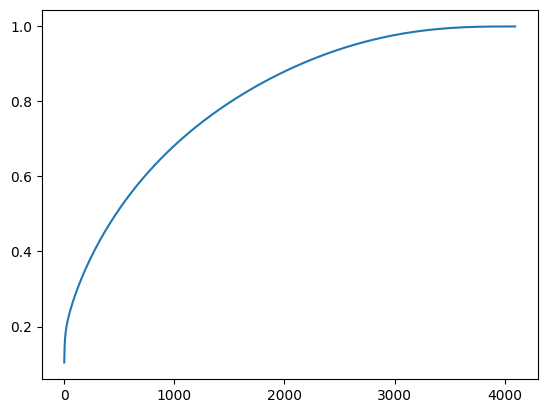

In [16]:
plt.plot(np.cumsum(Sh ** 2) / np.sum(Sh ** 2))

In [23]:
Vh[0].shape

(32000,)

In [22]:
for i in range(20):
    print('S', Sh[i])
    #u, v = U[:,i], V[:,i]
    #print('U ENTROPY', entropy(softmax(u)))
    #print('V ENTROPY', entropy(softmax(v)))
    print(pd.concat([topk(Uh[:,i]), topk(Vh[i])], axis=1))

S 26.656696
             token      prob        token      prob
0          archivi  0.000032           ,”  0.000032
1            textt  0.000032   ▁everybody  0.000032
2   ▁partiellement  0.000032            　  0.000032
3        ▁externos  0.000032           ."  0.000032
4         ▁esterni  0.000032           ▁â  0.000032
5          ▁eredet  0.000032           -(  0.000032
6      ▁információ  0.000031          ▁(.  0.000032
7              ira  0.000031     ▁whereas  0.000032
8               ip  0.000031           ▁‘  0.000032
9               ui  0.000031         ensk  0.000032
10             era  0.000031           -\  0.000032
11              iz  0.000031      ▁dissol  0.000032
12             ern  0.000031           .[  0.000032
13             uss  0.000031  ▁eredetiből  0.000032
14             ill  0.000031        mlung  0.000032
15              yn  0.000031            ~  0.000032
16              od  0.000031     ▁suppose  0.000032
17              ub  0.000031     multirow  0.000032
